### **📉ADAM OPTIMIZATION FROM SCRATCH.**

*Purpose: Implementing the ADAM optimizer from the ground up with PyTorch and comparing its performance on 6 3-D objective functions (each progressively more difficult to optimize) against SGD, AdaGrad, and RMSProp.*

In recent years, the Adam optimizer has become famous for achieving fast and accurate results when it comes to optimizing complex stochastic loss functions - thanks to its moment estimates (as I'll explain further) and update rule, it is able to more efficiently converge to reliable local (and sometimes global) minima, and has been shown to perform remarkably well on high-dimensional objective functions due to **a very small memory requirement - the optimization method is invariant to gradient scaling and does NOT need to compute higher order derivatives, thus making it more computationally efficient.**

The goal of this project is to 1️⃣ learn how optimization methods work mathematically and their theoretical behaviour (reading and taking notes on the paper + building a strong foundation of statistics), 2️⃣ apply this theoretical knowledge by constructing said optimizer from scratch in PyTorch (found in CustomAdam.py), and 3️⃣ test this custom implementation on six 3D functions against optimizers to determine performance. The objective of this last step was to see if I could **leverage the mathematical knowledge gained in a) to improve the optimizer. (Optimizer_Experimentation.ipynb).** 

This project was started in an effort to replicate the original 2017 paper! Check it out for more information and a more detailed explanation of how everything works under the hood - https://arxiv.org/pdf/1412.6980.pdf.

### **➗ How Adam Actually Works - The Math.**

**Fundamentally, the core aspect of ML that allows machine to "learn" is optimization** - taking a differentiable objective (loss) function and attempting to intelligently modify the model's parameters in such a way that it results in a lower (or higher) value of this function. This is done iteratively - the optimization algorithm uses something known as the **gradient** (simply the derivative of the loss function at that point) to determine how best to update all the parameters. Each one of these updates/iterations is known as a **"step"**, and over a large number of steps, the model should ideally **converge to a local minima that offers arbitrarily good parameters.** The *size* of these steps is known as the *stepsize or learning rate*, as we'll go over next.

Here's a quick GIF using the standard SGD (Stochastic Gradient Descent) Optimization Algorithm (source: https://mlfromscratch.com/optimizers-explained/):

<p align = "center"><img src = "./images/GRADIENT-DESCENT-GIF.gif"></img></p>

**The key disadvantage of this method is that it becomes computationally expensive extremely fast.** The image above showed a model with one parameter being optimized - but, practically, most models have **dozens if not hundreds of thousands of parameters** that must be optimized. In such cases, we have to compute the **nth order derivative of some cost function $Z(θ)$** where $θ$ is a vector of all of these parameters - a task that must be repeated **for each step we take.** This quite evidently slows down the optimization process and drastically increases the compute needed as well.

How does Adam fix this? *By using first and second moment ESTIMATES to update parameters rather than the gradient themselves.* 

(**Quickly, here are some terms worth noting:**

- **Expected Value:** this is given by $E[X]=∫^∞_{-∞}x*p(x)dx$, and its fundamental goal is to represent **the return you can obtain for performing some action.** In this case, $p(x)$ is the probability distribution of some random variable, and *x* is the variable itself. All in all, this gives the probability that some random event will occur.

- **First Moment:** this is given by $E[X]$, and simply yields the mean value of the given data.

- **Centered and Uncentered Moments:** the formula given for the expected value involves an integral; but, we can **APPROXIMATE THIS MOMENT WITH A SUM**, much like any integral can be approximated via a left or right Riemann sum. In that case, we simply do $prob*var + prob*var...$ for all the different probabilities and variables. This is known as the **uncentered** or raw moment. If we subtract the *mean from each and every variable value then we get the CENTERED moment.* Mathematically, it a centered moment would be yielded by $prob * (var - mean) + prob * (var - mean)...$ for all $n$ variables.

- **Second Moment (UNCENTERED AND CENTERED):** The second moment is the same as the first moment, except for the fact that **every x term is SQUARED.** So, the actual formula for a moment is **$m_n=E[X^n]**, where *n* refers to the given moment (first, second, etc.). The **second CENTERED MOMENT is the variance, whereas the second UNCENTERED moment is the uncentered variance or SQUARED DISTANCE FROM THE ORIGIN.** 

*P.S. - while there isn't enough room here to give full proofs of all of this, I've broken down the math for myself as I was learning it all in one spot https://crysta.notion.site/ADAM-A-METHOD-FOR-STOCHASTIC-OPTIMIZATION-758a789b929842d4ac01281e4366f9f5; check it out and scroll to the "Key Terms" section for a more detailed set of definitions*.)

By using these moment estimates, Adam is able to circumvent the high compute and training time for traditional optimization methods on high dimension problems. 

**Here's an exact breakdown of the algorithm:**

1. **Initialize zero-filled tensors** for the first moment estimate $m_0$ and the second uncentered moment estimate $v_0$, and set timestep $t$ (which keeps track of what iteration we are on) to zero.

(Repeat the following steps until converged)

2. **Increment timestep** ($t = t+1).

3. **Obtain the gradients: $g_t = ∇f_t(θ_{t-1})$**, where $f_t$ is the loss function, $θ$ is the parameter vector and $∇$ represents the act of taking the gradients (partial derivatives as we have more than one parameter; the derivative of a vector is known as a partial derivative) of the specified cost function. 

4. **Use a bias to estimate the first moment across all the gradients - $m_t = B_1 x m_{t-1} + (1 - B_1) x g_t$.** When optimizing, we want to limit the influence of outliers and one-off exploding gradients as much as possible - if the new gradient vector is substantially different than the existing ones, then we want to take the past vectors into consideration so as not to make disastrous, radically different updates. So, we add a **bias term to circumvent this - this bias decays exponentially as we progress**, thanks to the next couple of steps.

5. **Estimate the second uncentered moment.** Same philosophy as the above step, but this time $v_t$ is being updated and we are taking the **SQUARE OF THE GRADIENT** since we're computing the estimate of the second raw moment - $v_t = B_2 x (v_{t-1}) + (1 - B_2) * g_t^2$.

    - *Note that this equation is a moment estimate - $B_2$ acts as a probability, and $v_{t-1}$ and $g_t^2$ act as the "random" variables ($P(x)$ and $x$ in the expected value equation)*. The second uncentered moment requires that we *square each X*, which is why $g_t$ is squared.


6. **Correct the bias introduced in the first moment estimate - $m^{Δ}_t=m_t/(1-B_1^t)$**. I won't go into too much detail into why exactly we need to do this here, but it's relatively simple - as mentioned earlier, our "sum" method is an approximation of the moments instead of the true moment (which would be found by taking the integral in the expected formula). If we take the integral of the above formula to find $E[v]$, we are left with $E[g] x (1 - B_2) + C$, meaning that we are a factor of $(1 - B_2)$ off from the true second raw moment $E[g]$. **So, simply divide the moment estimate $m_t$ by $(1 - B_2)$ to correct for the added bias - yielding $m^{Δ}$.** Furthermore, note that we are dividing by 1 minus the *bias raised to the power 2.* This is, in essence, decaying the bias and **shrinking m^{Δ} as t (our current step) grows larger and larger.**

7. **Correct the bias introduced in the *second* uncentered moment estimate - $v_t^{Δ}=v_t/(1-B_2^t)$.** Exact same principle as step #6, but applied to $v_t$.9

8. **Update the parameters $θ$: $θ_t=θ_{t-1} - \frac{α}{√(v^Δ_t)+ε}*m^Δ_t$.** Let's break this down:
    - $α$ represents the stepsize. This, along with $a(1-B_1)/√(1-B_2)$, serve as the upper bound for the effective step that the optimizer can take. For more depth on this, checkout the "Information about the algorithm" section in my Notion link above, or the original paper.

    - $m^{Δ}$ represents the first moment bias-corrected moment estimate computed in step 7.

    - $v^t{Δ}$ represents the second uncentered bias-corrected moment estimate computed in step 6.

    - $ε$ is an arbitrary constant (usually 10e-8) added in the denominator to avoid division by zero. We'll be ignoring this, as it's extremely small size makes it effectively irrelevant when taking a step.

    Why are we multiplying $α$ by $\frac{m^Δ_t}{√(v^Δ_t)}$? Note that the latter is, roughly speaking, the first moment divided by the second moment - the mean divided by the mean distance from the origin. Note that $v^Δ$ yields the AVERAGE SQUARED DISTANCE from the origin (it would yield avg sq distance from the mean if the moment was centered), and thus the square root is needed to yield the raw avg. sq. distance from the origin.

    **In the paper, this expression ($\frac{m^Δ_t}{√(v^Δ_t)}$) is known as the *signal to noise ratio*.** The idea is that we want to REDUCE the stepsize if we are more unsure of what the ideal step would be - meaning that that the value of the factor that we multiply the stepsize with should be *closer to zero/have a larger denominator* if there is more *variability* across the gradient estimates. More specifically, **if the gradients have more spread w.r.t the origin despite the mean being SMALL (0), then this indicates that there is high degree of uncertainty** - and, as the mean and the spread w.r.t the origin are both the first moment and the second uncentered moment respectively, the SNR will be a much smaller value as the denominator grows larger than the numerator. If both are high, then this means there is a strong signal for an update in a certain direction (**meaning that the SNR should be closer to one and thus allow for a step of the full stepsize**). 

    Fundamentally, this is a form of **stepsize annealing** - the step size is adjusted **dynamically and grows smaller and smaller as we begin approaching a minima and the gradients begin to shrink.**

Here's a full picture of all of these steps summarized (as presented in the paper):

<p align = "center"><img src = "./images/ADAM_ALGORITHM.jpg"></img></p>

In [2]:
#Import libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
#We want to test different optimizers using different optimizer evaluation functions
#Run each optimizer across a) the Rosenbrock function, b) Local Minima filled functions, c) Bowl-Shaped functions, d) Plate-Shaped functions
# and e) Functions with Steep drops

#After running each optimizer across these functions, take the average across all functions and plot to determine average performance
#Generate x data for each test - use same initialization distribution to ensure reproducibility and fairness while testing
import math

#Class to test optimizer
class OptimizerTest():
    #Initialize optimizer testing object
    def __init__(self, Optimizer, epochs, params, **opt_args):
        #Set the parameters to an initial x and y value, optimize_(var) variables will be modiifed in the optimization process via the optimizeParams() method
        self.params = params
        #Set both the initial and optimized versions of x and y to COPIES of the original parameter such as to not modify the input tensor
        self.initial_x, self.initial_y = torch.clone(self.params)
        #Save optional arguments for future object creation
        self.opt_args = opt_args
        #Save optimizer type for same purpose
        self.optimizer_type = Optimizer
        #Instantiate new Optimizer object - check if optional keyword arguments (specific arguments for the optimizer) have been provided
        if self.opt_args != {}:
            self.vals = [args for args in self.opt_args.values()]
            self.optimizer = Optimizer([self.params], *self.vals)
        else: self.optimizer = Optimizer([self.params])
        #Set both the initial and optimized versions of x and y to COPIES of the original parameter such as to not modify the input tensor
        self.initial_x, self.initial_y = torch.clone(self.params)
        #Set epochs
        self.epochs = epochs

    #Optimize the loss function on a given loss function
    def optimizeParams(self, loss_function):
        #Fit the given 3D function
        #Store losses (z values) obtained via optimizing this function
        losses = []
        points = []
        #Iterate over number of epochs
        for epoch in range(self.epochs):
            #Set all gradients to zero - this is to prevent gradient accumulation as they do not reset per epoch
            self.optimizer.zero_grad()
            #Compute the loss
            x, y = self.params
            loss = loss_function(x, y)
            #Compute the gradients
            loss.backward()
            #Run the optimizer
            self.optimizer.step()
            #Add loss to loss array - use item() for both this append and the next one to extract the raw scalar as opposed to adding the tensor
            #Adding the tensor directly causes unexpected behaviour as the optimizer directly modifies the base; thereby changing all views and raising exceptions
            losses.append(loss.item())
            #Append points to point array for visualization and evaluation
            points.append([x.item(), y.item(), loss.item()])
        #Add losses array to dictionary of all optimization functions
        #To find the name of the function given, use the .__name__ method
        self.all_losses["{}".format(loss_function.__name__)] = losses
        self.all_points["{}".format(loss_function.__name__)] = points
        
    #Method to run tests - create a new LossFunctions object, and run the optimization method on all of those functions
    def runTests(self):
        #Create dictionary of all losses
        self.all_losses = {}
        #Create dictionary of all points
        self.all_points = {}
        #Create new LossFunctions object to obtain various testing functions
        TestFunctions = LossFunctions(self.params)
        #Define list of loss functions we would like to optimize from Lossfunctions
        self.loss_opt_funcs = ["RosenbrockLoss", "BukinLoss", "BohachevskyLoss", "BoothLoss", "CamelLoss", "EasomLoss"]
        #Optimize each given loss function (call optimizeParams for each function in the list)
        for loss_func in self.loss_opt_funcs:
            func = eval('TestFunctions.{}'.format(loss_func))
            self.optimizeParams(func)
            #Reset the optimized parameters back to the initial values - this ensures that each test starts off with the same values
            self.params = torch.tensor((self.initial_x, self.initial_y), requires_grad = True, dtype = torch.float64)
            #Create a new optimizer object - each instance of the optimizer is meant to optimize one loss function
            #As the optimization task is done, create a new instance of the optimizer
            if self.opt_args != {}:
                self.vals = [args for args in self.opt_args.values()]
                self.optimizer = self.optimizer_type([self.params], *self.vals)
            else: self.optimizer = self.optimizer_type([self.params]) 
        return self.all_losses, self.all_points
    
#Define class of all loss functions being used
#Methods to calculate the losses dependent on the function - given a set of x and y points, these functions will determine the respective z coordinate (which is our loss)
#The optimizers chosen will need to optimize this function and arive at its local minima; as all have two input parameters, they form a three dimensional graph
class LossFunctions():
    #Initialize x and y values from params upon initialization - these are the x and y values that each test will start with (before they are updated)
    def __init__(self, params): self.initial_x, self.initial_y = params

    #Rosenbrock function - one of the most famous functions for evaluating optimization methods
    def RosenbrockLoss(self, x, y):
        term_1 = torch.pow(1.0 - x, 2)
        term_2 = 100 * torch.pow(torch.subtract(y, torch.pow(x, 2)), 2)
        return torch.add(term_1, term_2)

    #Bukin Function (testing for many local minima)
    def BukinLoss(self, x, y):
        #Equation - z = 100sqr(|y-0.01x^2|)+0.01(x+10)
        term_1 = 100 * torch.abs(y - (0.01 * torch.pow(x, 2)))
        return term_1 + (0.01 * torch.abs(x + 10))

    #Bohachevsky Functions (testing to see if optimizer works on bowl-shaped functions)
    def BohachevskyLoss(self, x, y):
        #Equation - z = x^2 + 2y^2 - 0.3cos(3pix) - 0.4cos(4piy) + 0.7
        cosine_term_1 = 0.3 * torch.cos(3 * math.pi * x)
        cosine_term_2 = 0.4 * torch.cos(4 * math.pi * x)
        return torch.pow(x, 2) + (2 * torch.pow(y, 2)) - cosine_term_1 - cosine_term_2 + 0.7
    
    #Booth Function (Plate shaped function)
    def BoothLoss(self, x, y):
        #Equation - z = (x + 2y - 7)^2 + (2x + y -5)^2
        term_1 = torch.pow(x + (2 * y) - 7, 2)
        term_2 = torch.pow(2 * x - 5, 2)
        return term_1 + term_2
    
    #"Six-Hump" Camel function (function with six local minima)
    def CamelLoss(self, x, y):
        #Equation - z = (4 - 2.1x^2 + x^4/3)x^2 + xy + (-4 + 4y^2)y^2
        term_1 = torch.mul(4 - 2.1 * torch.pow(x, 2) + (torch.pow(x, 4)/3), torch.pow(x, 2))
        term_3 = torch.mul((-4 + 4*torch.pow(y, 2)), torch.pow(y, 2))
        return term_1 + torch.mul(x, y) + term_3
    
    #Easom Function (has very steep drops but is otherwise unimodal - the minimum takes a small space relative to the search space of the function)
    def EasomLoss(self, x, y):
        #Equation - z = -cos(x)cos(y)exp(-(x-pi)^2-(y-pi)^2)
        cosine_term = - torch.mul(torch.cos(x), torch.cos(y))
        exponential_term = torch.subtract(-torch.pow(x - math.pi, 2), torch.pow(y - math.pi, 2))
        return torch.mul(cosine_term, torch.exp(exponential_term))

#Function to calculate the loss (Euclidean distance between current point and global minima)
#The loss will be the DISTANCE from the local minima to the gradient - we're measuring how fast the optimizer can reach this minima
def computeEuclideanLoss(current_point, global_minima):
    #Compute the squared difference between the two vectors
    squared_difference = torch.float_power(torch.subtract(current_point, global_minima), 2.0)
    #Add all squared differences, convert the resulting scalar to a float, and then take the square root
    return torch.sqrt(torch.sum(squared_difference))

In [4]:
#Initialize x and y vectors - 3D functions will be written in the form z(x, y)
#Both x and y will be initialized with normal distributions from ranges -5 to 5
from random import uniform
x = uniform(-1, 1)
y = uniform(-1, 1)
#Create tuple and convert to tensor
XY = (x, y)

#Import Custom Adam Optimizer Implementation and all other optimizers
from CustomAdam import CustomAdam
from torch.optim import SGD, Adagrad, RMSprop
#List of all optimizers
optimizers = ["CustomAdam", "SGD", "Adagrad", "RMSprop"]
#Dictionary of all losses
optimizer_losses = {}
#Dictionary of all points traversed during the optimization process
optimizer_points = {}
#List of all objective functions
loss_funcs = ["Rosenbrock", "Bukin", "Bohachevsky", "Booth", "Camel", "Easom"]

#Number of steps to run optimizers - the Adam paper iterated 200 times over the entire MNIST dataset (roughly 60k * 200 steps)
#Taking compute into account, the optimizer will run for 60k steps (once over the dataset)
steps = 60000
#Iterate over all optimizers
for opt in optimizers:
    #Redefine every iteration as these parameters are optimzied and therefore modified - we want the same set of parameters to be passed into all optimizer tests
    #Redefining the tensor also cuts off all existing gradients
    XY_TENSOR = torch.tensor(XY, requires_grad = True, dtype = torch.float64)
    #Run optimizer tests on given tensor - create a new Optimizer test object and call runTests()
    #If the optimizer is SGD, add the required learning rate parameter (same as the Adam stepsize)
    if opt == "SGD":
        TestInstance = OptimizerTest(Optimizer = eval(opt), epochs = steps, params = XY_TENSOR, lr = 0.001)
    else: TestInstance = OptimizerTest(Optimizer = eval(opt), epochs = steps, params = XY_TENSOR)
    optimizer_losses[opt], optimizer_points[opt] = TestInstance.runTests()

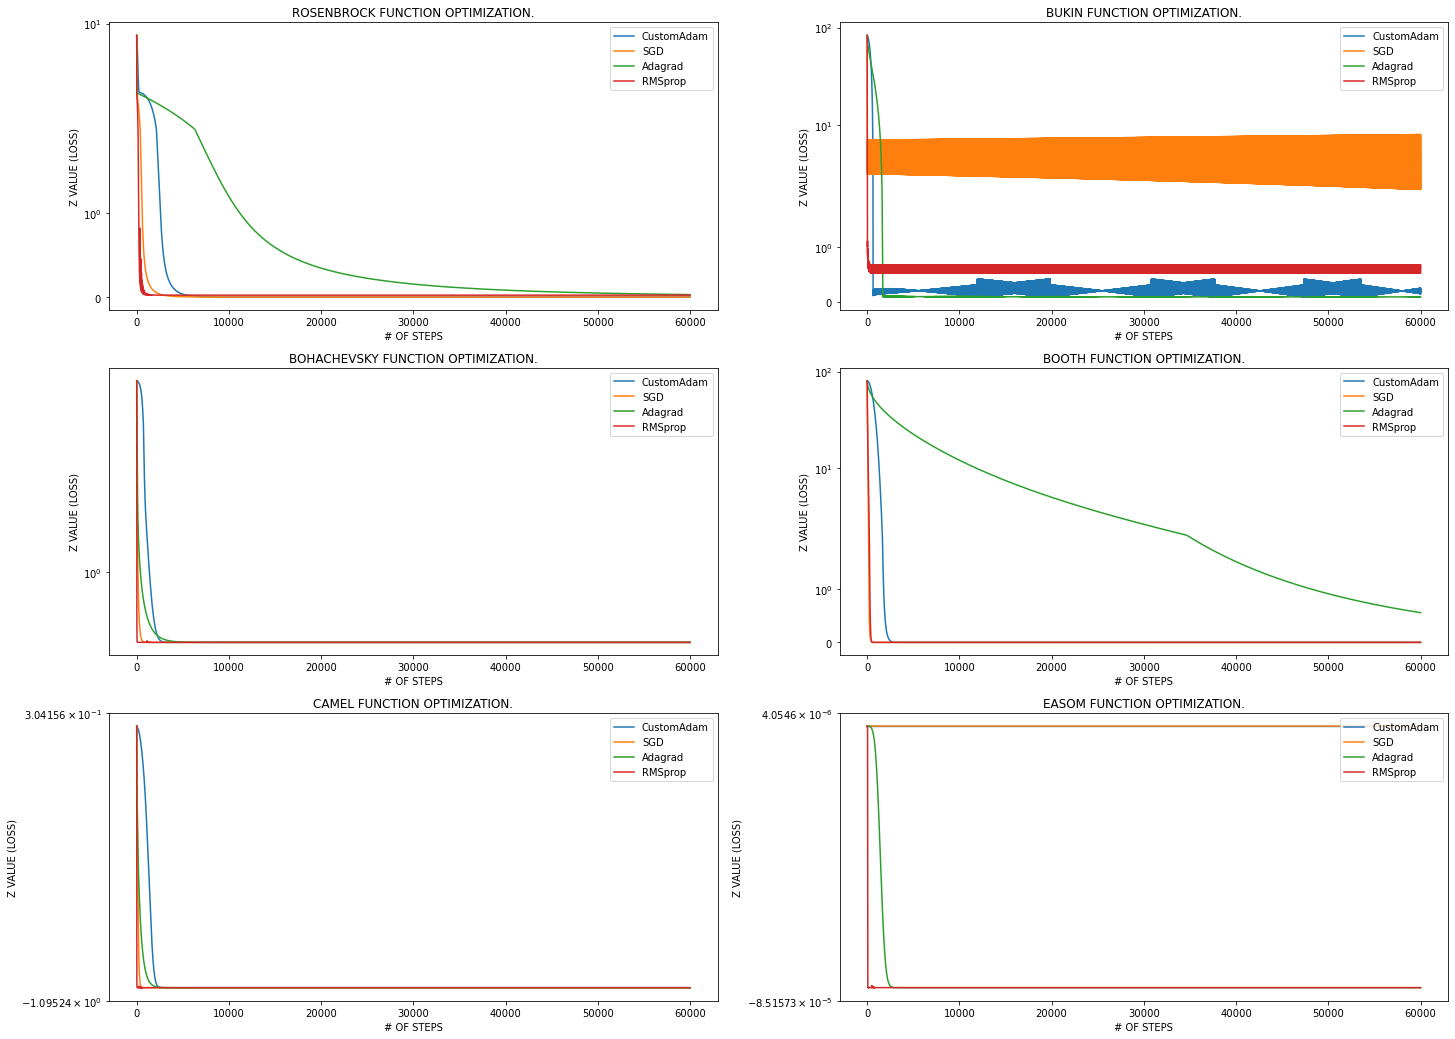

In [9]:
#Plot losses for each test function and compare to determine optimizer convergence speed and duration
#Import libraries
import matplotlib.pyplot as plt
%matplotlib inline

#Create subplot
loss_plot, [[Rosenbrock_ax, Bukin_ax], [Bohachevsky_ax, Booth_ax], [Camel_ax, Easom_ax]] = plt.subplots(3, 2, figsize = (24, 18))
#Function to plot losses for a particular objective function w.r.t all optimizers
def plotLosses(loss_func):
    #Iterate over each optimizer
    for optimizer in optimizers:
        #Plot optimizer's losses over the # of epochs
        globals()[loss_func + "_ax"].plot(optimizer_losses[optimizer][loss_func + "Loss"], label = optimizer)
    #Set title and x and y labels
    globals()[loss_func + "_ax"].set_title(loss_func.upper() + " FUNCTION OPTIMIZATION.")
    globals()[loss_func + "_ax"].set_xlabel("# OF STEPS")
    globals()[loss_func + "_ax"].set_ylabel("Z VALUE (LOSS)")
    #Display legend
    globals()[loss_func + "_ax"].legend(loc = "upper right")
    #Set to logarithmic scale to better see differences in updates as loss values become increasingly small
    globals()[loss_func + "_ax"].set_yscale("symlog")

#Plot losses for each loss function
for loss_func in loss_funcs:
    plotLosses(loss_func)

In [ ]:
#Create 3D-animation to visualize optimization process
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
%matplotlib inline

figure = plt.figure()
ax = plt.axes(projection = "3d")